In [69]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [70]:
env = BlackjackEnv()

In [71]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    return lambda x: np.argmax(Q[x]) if np.random.random() > epsilon else np.random.choice(range(nA), 1)[0]

In [72]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    for ie in range(num_episodes):
        if (ie+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(ie+1, num_episodes), end="")
            sys.stdout.flush()
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        observation = env.reset()
        done = False
        reward_list = []
        observation_list = [observation]
        action_list = []
        G = 0
        for t in range(100):
            action = policy(observation)
            observation, reward, done, _ = env.step(action)
            reward_list.append(reward)
            observation_list.append(observation)
            action_list.append(action)
            if done:
                break
        for i in range(len(reward_list))[::-1]:
            G = G*discount_factor + reward_list[i]
            prev_count = returns_count[observation_list[i]][action_list[i]]
            returns_count[observation_list[i]][action_list[i]] += 1.0
            prev_q = Q[observation_list[i]][action_list[i]]
            Q[observation_list[i]][action_list[i]] += (G - prev_q) / (prev_count + 1)
    return Q, policy

In [73]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

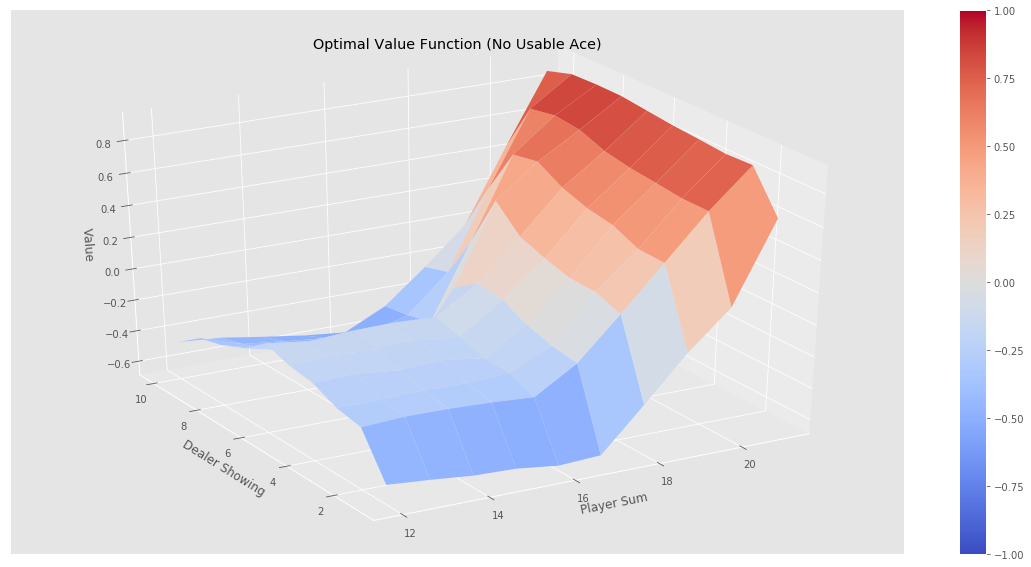

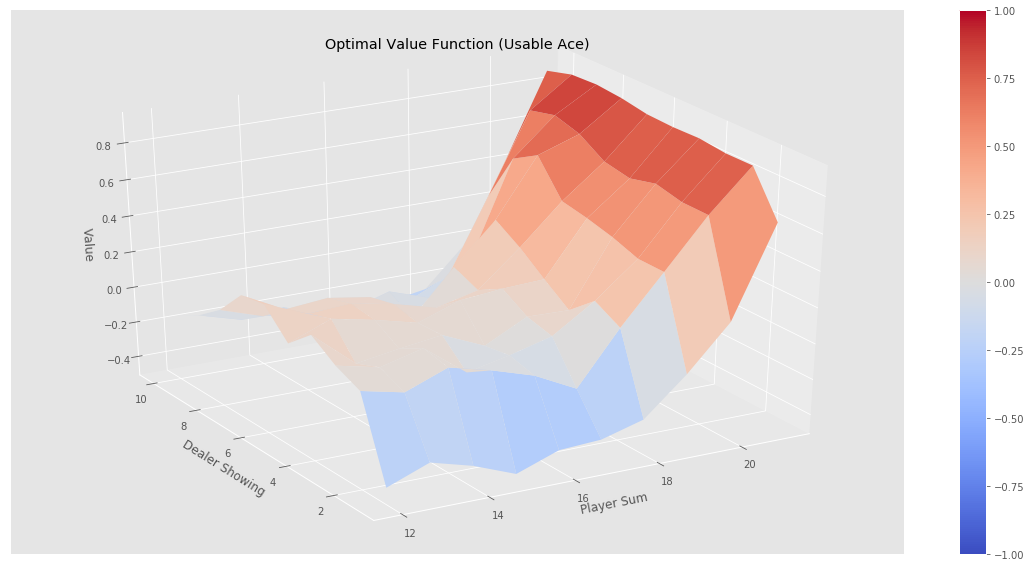

In [74]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

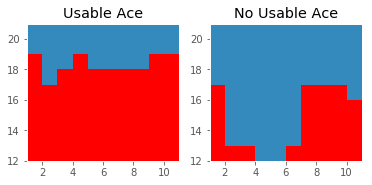

In [75]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(121, aspect='equal', ylim=[12,21], xlim=[1,11], title="Usable Ace")
ax2 = fig1.add_subplot(122, aspect='equal', ylim=[12,21], xlim=[1,11], title="No Usable Ace")

for state, action_arr in Q.items():
    score, dealer, ace = state
    action = np.argmax(action_arr)
    facecolor = "red" if action == 1 else None
    if ace:
        ax1.add_patch(patches.Rectangle((float(dealer), float(score)), 1.0, 1.0, facecolor=facecolor))
    else:
        ax2.add_patch(patches.Rectangle((float(dealer), float(score)), 1.0, 1.0, facecolor=facecolor))